In [2]:
import json
import os
import matplotlib as mpl
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
ROOT_DIR = '/mnt/home/floyed/code_for_brain_align'
DATA_DIR = f"{ROOT_DIR}/data"
SCRIPTS_DIR = f"{ROOT_DIR}/scripts"
FIGURES_DIR = f"{ROOT_DIR}/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

In [4]:
language_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/language_trained.parquet')

# Remove all colum with nan
language_df = language_df.dropna(axis=1, how='all')

language_df['step'] = language_df['src_model'].str.split('_step').str[1].astype(int)
language_df['src_model'] = language_df['src_model'].str.split('_step').str[0]

token_per_step = 2_097_152
language_df['tokens'] = language_df['step'] * token_per_step


In [5]:
language_max_region_df = (
    language_df.groupby(
        [
            'src_model',
            'tokens',
            'tgt_model',
            'src_feature'
        ],
        as_index=False
    )[[
        'score',
    ]]
    .apply(lambda x: x.nlargest(1, "score").mean() * 2)
    .reset_index(drop=True)
)


language_max_region_df_avg_subj = (
    language_max_region_df.groupby(
        [
            'src_model',
            'tokens',
            'src_feature'
        ],
        as_index=False
    )[[
        'score',
    ]]
    .apply(lambda x: x.nlargest(1, "score").mean())
    .reset_index(drop=True)
)

In [28]:
DEFAULT_MODELS = [
    "pythia-70m-deduped",
    "pythia-160m-deduped",
    "pythia-410m-deduped",
    "pythia-1b-deduped",
    "pythia-1.4b-deduped",
    "pythia-2.8b-deduped",
]

DEFAULT_REVISIONS = [f"step{x}" for x in
                     [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]]

In [29]:
language_performance_list = []

for model in DEFAULT_MODELS:
    benchmark_path = f"{ROOT_DIR}/data/utils/pythia-v1/{model}/zero-shot"
    if not os.path.exists(benchmark_path):
        print(f"Could not find {model} in {benchmark_path}")
        continue
    for json_file in os.listdir(benchmark_path):
        if json_file.endswith(".json"):
            step = int(json_file.split("step")[1].split(".json")[0])

            with open(f"{benchmark_path}/{json_file}", 'r') as f:
                data = json.load(f)['results']

            language_performance_list.append({
                "src_model": model,
                "step": step * token_per_step,
                "lambada_openai": data["lambada_openai"]["acc"],
                "sciq": data["sciq"]["acc"],
                "piqa": data["piqa"]["acc"],
                "winogrande": data["winogrande"]["acc"],
                "logiqa": data["logiqa"]["acc"],
                "arc_easy": data["arc_easy"]["acc"],
                "arc_challenge": data["arc_challenge"]["acc"],

            })

language_performance_df = pd.DataFrame(language_performance_list)

# sort by step
language_performance_df = language_performance_df.sort_values(by=["step"])

In [30]:
plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

Saved lambada_openai plot


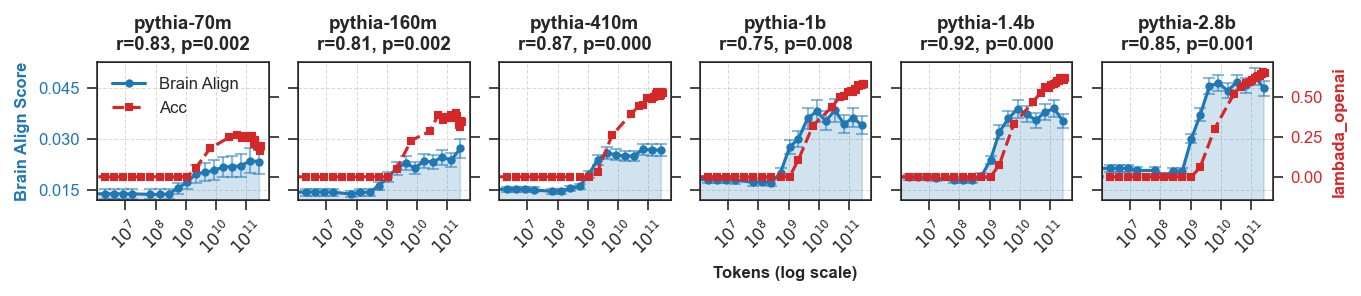

Saved sciq plot


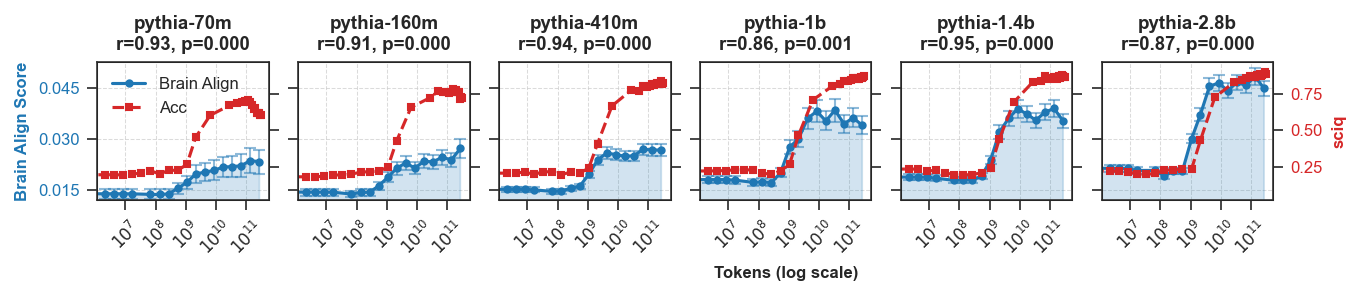

Saved piqa plot


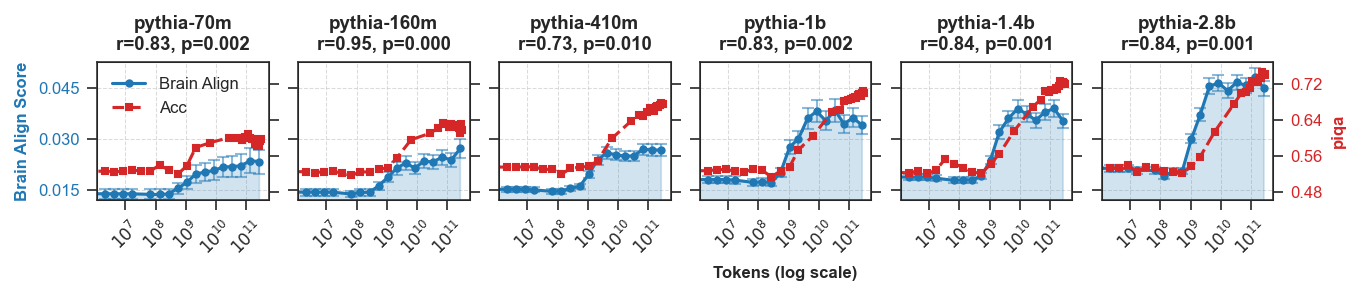

Saved winogrande plot


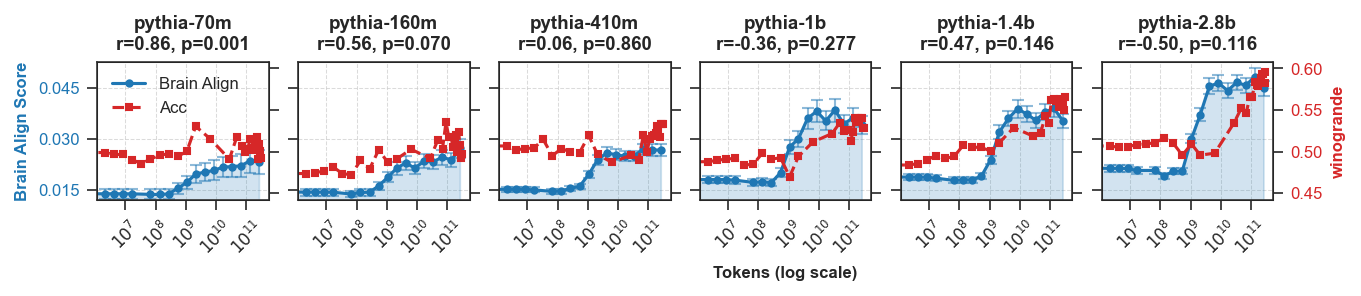

Saved logiqa plot


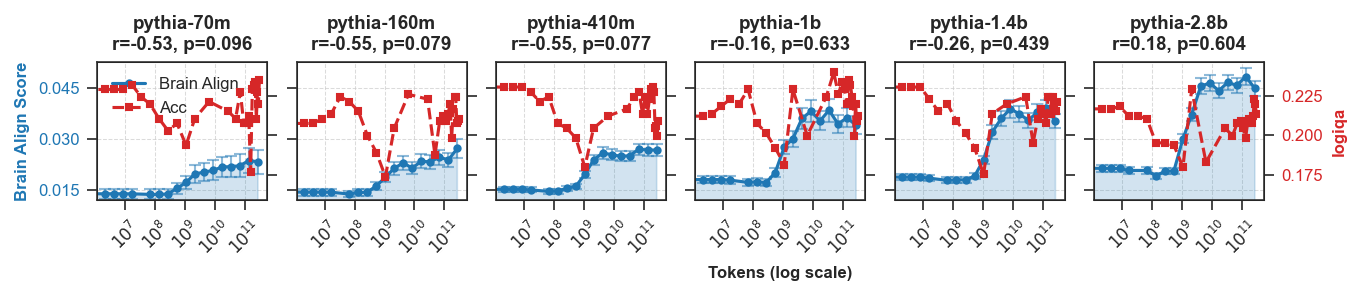

Saved arc_easy plot


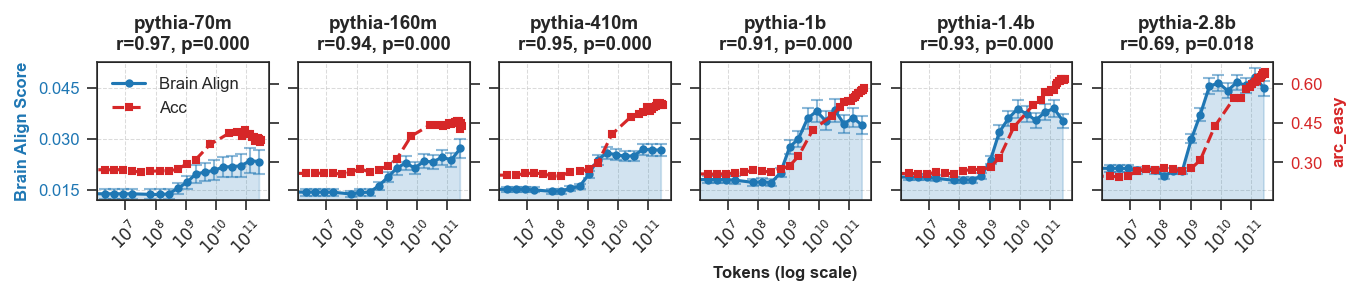

Saved arc_challenge plot


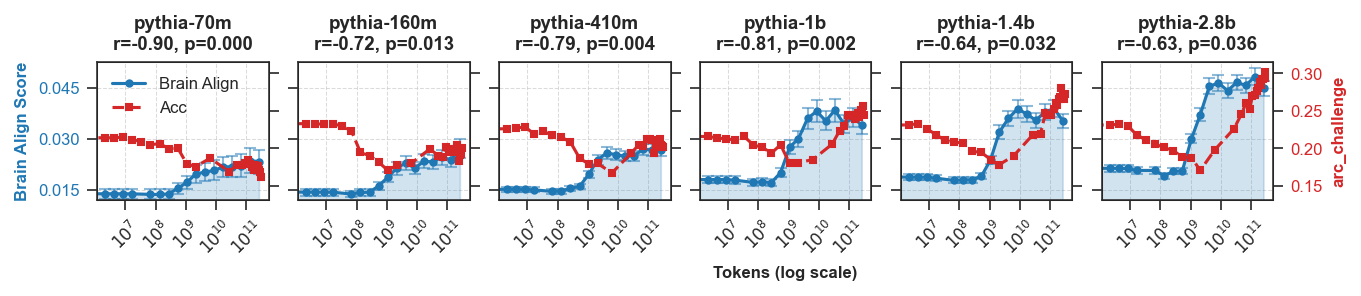

In [34]:
import matplotlib as mpl
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, LogLocator, FuncFormatter

benchmarks = ['lambada_openai', 'sciq', 'piqa', 'winogrande', 'logiqa', 'arc_easy', 'arc_challenge']
# Define custom colors
brain_color = "#1f77b4"  # Blue for brain Align
benchmark_color = "#d62728"  # Red for benchmark error rate

def format_func(x, pos):
    if x == 0:
        return '0'
    else:
        exponent = int(np.log10(x))
        return r'$10^{%d}$' % exponent

# For each benchmark, create a separate row of plots (one for each model)
for benchmark in benchmarks:
    # Create a figure for this benchmark with reduced spacing between subplots
    fig, axes = plt.subplots(1, len(DEFAULT_MODELS), figsize=(9, 1.9))
    fig.subplots_adjust(wspace=0.15)  # Reduced spacing between subplots

    # Get benchmark data for this model
    ax2_ymax = language_performance_df[benchmark].max()
    ax2_ymin = language_performance_df[benchmark].min()

    ax2_ymax = ax2_ymax + (ax2_ymax - ax2_ymin) * 0.10
    ax2_ymin = ax2_ymin - (ax2_ymax - ax2_ymin) * 0.20

    # For each model, create a dual y-axis plot
    for i, model in enumerate(DEFAULT_MODELS):
        ax1 = axes[i]

        # Get brain Align data for this model
        brain_data = language_max_region_df[language_max_region_df['src_model'] == model]

        # Group by tokens and calculate mean and std for error bars
        grouped_brain = brain_data.groupby('tokens')['score'].agg(['mean', 'std', 'count']).reset_index()
        grouped_brain.fillna({'std': 0}, inplace=True)  # Handle NaN values in std

        # Calculate 95% confidence interval (CI)
        grouped_brain['ci_95'] = grouped_brain.apply(
            lambda row: stats.t.ppf(0.975, row['count']-1) * row['std'] / np.sqrt(row['count'])
            if row['count'] > 1 else 0, axis=1)

        # Plot brain Align score with error bars
        brain_line, = ax1.plot(grouped_brain['tokens'], grouped_brain['mean'],
                 color=brain_color, marker='o', markersize=3, linewidth=1.5,
                 label='Brain Align')

        # Add error bars with 95% CI
        ax1.errorbar(grouped_brain['tokens'], grouped_brain['mean'],
                    yerr=grouped_brain['ci_95'],
                    fmt='none', ecolor=brain_color, alpha=0.5,
                    capsize=3, capthick=1)

        # Add light shadow/area under the curve for visual emphasis
        ax1.fill_between(grouped_brain['tokens'], 0, grouped_brain['mean'],
                         color=brain_color, alpha=0.2)

        ax1.set_xscale('log')
        ax1.set_ylim(0.012, 0.0525)

        # Reduce y-tick density on first axis
        ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

        # Set up x-axis with scientific notation for all major ticks
        ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
        ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=5))

        # Create second y-axis for benchmark error rate
        ax2 = ax1.twinx()

        ax2.set_ylim(ax2_ymin, ax2_ymax)

        # Reduce y-tick density on second axis
        ax2.yaxis.set_major_locator(plt.MaxNLocator(4))

        # Show y-axis labels and ticks only on leftmost and rightmost plots
        if i == 0:
            # Only show left y-axis (Brain Align) on leftmost plot
            ax1.set_ylabel('Brain Align Score', color=brain_color, fontweight='bold')
            ax1.tick_params(axis='y', labelcolor=brain_color)
            # Hide right y-axis ticks on leftmost plot
            ax2.tick_params(axis='y', labelleft=False, labelright=False)
        elif i == len(DEFAULT_MODELS) - 1:
            # Only show right y-axis (Error Rate) on rightmost plot
            ax2.set_ylabel(benchmark, color=benchmark_color, fontweight='bold')
            ax2.tick_params(axis='y', labelcolor=benchmark_color)
            # Hide left y-axis ticks on rightmost plot
            ax1.tick_params(axis='y', labelleft=False, labelright=False)
        else:
            # Hide both y-axes ticks on middle plots
            ax1.tick_params(axis='y', labelleft=False, labelright=False)
            ax2.tick_params(axis='y', labelleft=False, labelright=False)

        # Get benchmark data for this model
        perf_data = language_performance_df[language_performance_df['src_model'] == model]

        # Plot the data and calculate correlation
        if benchmark in perf_data.columns:
            error_rate = perf_data[benchmark]
            # Plot benchmark error rate
            error_line, = ax2.plot(perf_data['step'], error_rate,
                     color=benchmark_color, linestyle='--', marker='s',
                     markersize=3, linewidth=1.5, label='Acc')

            # Calculate Pearson correlation between Brain Align scores and benchmark performance
            # First, we need to align the data points based on tokens/steps
            brain_tokens = grouped_brain['tokens'].values
            perf_steps = perf_data['step'].values

            # Find common x-values (tokens/steps) to calculate correlation
            common_x = np.intersect1d(brain_tokens, perf_steps)

            if len(common_x) > 1:  # Need at least 2 points for correlation
                brain_values = [grouped_brain[grouped_brain['tokens'] == x]['mean'].values[0] for x in common_x]
                perf_values = [error_rate[perf_data['step'] == x].values[0] for x in common_x]

                # Calculate Pearson correlation and p-value
                corr, p_value = stats.pearsonr(brain_values, perf_values)

                # Add correlation and p-value to the title
                model_str = model[:-8]
                ax1.set_title(f'{model_str}\nr={corr:.2f}, p={p_value:.3f}', fontweight='bold')
            else:
                # Not enough data points for correlation
                model_str = model[:-8]
                ax1.set_title(f'{model_str}\n(insufficient data for corr)', fontweight='bold')

            # Add legend to the first plot (i=0) in each benchmark row
            if i == 0:
                # Create legend for both lines in the first plot
                lines = [brain_line, error_line]
                labels = ['Brain Align', 'Acc']
                ax1.legend(lines, labels, loc='upper left', frameon=False)
        else:
            # No benchmark data available
            model_str = model[:-8]
            ax1.set_title(f'{model_str}', fontweight='bold')

        # Only add x-axis label to middle plots
        if i == len(DEFAULT_MODELS) // 2:
            ax1.set_xlabel('Tokens (log scale)', fontweight='bold')

        ax1.tick_params(axis='x', rotation=45)

        # Make spines thinner to match tick thickness
        for spine in ax1.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)  # Thinner lines to match tick thickness
            spine.set_edgecolor('#333333')

        # Add grid for better readability
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Set tick parameters to be thinner
        ax1.tick_params(axis='both', width=0.8)
        ax2.tick_params(axis='both', width=0.8)

    # Tight layout with additional padding reduction
    plt.tight_layout(pad=0.5)

    os.makedirs(f'{FIGURES_DIR}/training/language/performance', exist_ok=True)
    plt.savefig(f'{FIGURES_DIR}/training/language/performance/{benchmark}.pdf', bbox_inches='tight')
    print(f'Saved {benchmark} plot')
    plt.show()

/mnt/home/floyed/code_for_brain_align/figures/wo_title.pdf


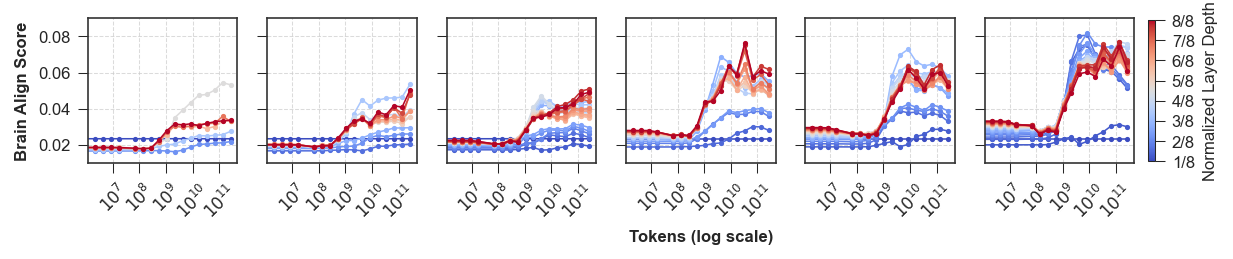

/mnt/home/floyed/code_for_brain_align/figures/w_title.pdf


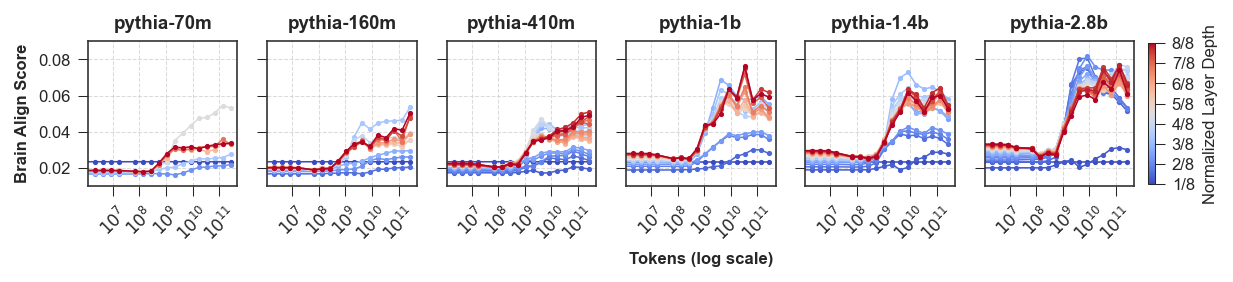

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, LogLocator, FuncFormatter

# Define custom colors
brain_color = "#1f77b4"  # Blue for brain Align
benchmark_color = "#d62728"  # Red for benchmark error rate
for title in [False, True]:
    # Create a colormap for layers
    layer_cmap = plt.get_cmap('coolwarm')

    # For the layer visualization, create one consolidated figure with 6 subplots (one per model)
    fig2, axes2 = plt.subplots(1, len(DEFAULT_MODELS), figsize=(9, 1.25))
    fig2.subplots_adjust(wspace=0.2)  # Reduced spacing between subplots

    # Get max number of layers across all models for consistent coloring
    max_layers = max([len(language_max_region_df_avg_subj[language_max_region_df_avg_subj['src_model'] == model]['src_feature'].unique())
                     for model in DEFAULT_MODELS])

    # Create a normalization for the colormap
    norm = mpl.colors.Normalize(vmin=0, vmax=max_layers-1)


    # For each model, create a plot showing layer-wise scores
    for i, model in enumerate(DEFAULT_MODELS):
        ax = axes2[i]

        # Get data for this model
        data = language_max_region_df_avg_subj[language_max_region_df_avg_subj['src_model'] == model]

        # Get layers and sort them
        layers = sorted(data['src_feature'].unique(),
                       key=lambda x: int(x.replace('layer', '')) if 'layer' in str(x) and x.replace('layer', '').isdigit() else x)

        # Plot each layer
        for j, layer in enumerate(layers):
            layer_data = data[data['src_feature'] == layer]

            # Get values for this layer
            x_values = layer_data['tokens'].values
            y_values = layer_data['score'].values

            # Sort the values by x for proper smoothing
            sort_idx = np.argsort(x_values)
            x_sorted = x_values[sort_idx]
            y_sorted = y_values[sort_idx]

            # Use the layer's position for consistent coloring
            color = layer_cmap(j / max(1, len(layers)-1))

            ax.plot(x_sorted, y_sorted,
                    color=color, marker='o', markersize=1.5, linewidth=0.75)

        # Format the plot
        ax.set_xscale('log')
        ax.set_ylim(0.01, 0.09)

        # Only show y-ticks and label on leftmost plot
        if i == 0:
            ax.set_ylabel('Brain Align Score', fontweight='bold')
        else:
            ax.tick_params(axis='y', labelleft=False)

        # Extract model name without the suffix for a cleaner display
        model_str = model[:-8] if len(model) > 8 else model
        if title:
            ax.set_title(f'{model_str}', fontweight='bold')

        # Add x-axis label to middle plots
        if i == len(DEFAULT_MODELS) // 2:
            ax.set_xlabel('Tokens (log scale)', fontweight='bold')

        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)

        # Format x-axis to show scientific notation
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'$10^{{{int(np.log10(x))}}}$' if x > 0 else '0'))
        ax.xaxis.set_major_locator(LogLocator(base=10, numticks=5))
        ax.tick_params(axis='x', rotation=45)

        # Add a box around the plot for better visibility
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)  # Thinner lines to match tick thickness
            spine.set_edgecolor('#333333')

    # Create a custom colorbar
    cax = fig2.add_axes([0.91, 0.12, 0.005, 0.75])  # [left, bottom, width, height]
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=layer_cmap, norm=norm, orientation='vertical')

    # Create normalized labels (1/8, 2/8, etc.)
    num_ticks = 8  # You can adjust this number based on preference
    tick_positions = np.linspace(0, max_layers-1, num_ticks)
    tick_labels = [f"{i+1}/{num_ticks}" for i in range(num_ticks)]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Normalized Layer Depth')

    os.makedirs(f'{FIGURES_DIR}/training/language/layer-wise', exist_ok=True)

    if title:
        filename = 'w_title'
    else:
        filename = 'wo_title'
    plt.savefig(f'{FIGURES_DIR}/training/language/layer-wise/{filename}.pdf', bbox_inches='tight')
    print(f'{FIGURES_DIR}/{filename}.pdf')
    plt.show()

## Vision

In [24]:
vision_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/vision_trained.parquet')

# Remove all colum with nan
vision_df = vision_df.dropna(axis=1, how='all')

vision_df['step'] = vision_df['src_model'].str.split('---').str[1].astype(int)
vision_df['src_model'] = vision_df['src_model'].str.split('---').str[0]

sample_per_epoch = 1_281_167
vision_df['samples'] = vision_df['step'] * sample_per_epoch

vision_max_region_df = (
    vision_df.groupby(
        [
            'src_model',
            'samples',
            'tgt_model',
            'src_feature'
        ],
        as_index=False
    )[[
        'score',
    ]]
    .apply(lambda x: x.nlargest(1, "score").mean())
    .reset_index(drop=True)
)

for sample in vision_max_region_df['samples'].unique():
    sub_df = vision_df[vision_df['samples'] == sample]
    _mean, _std = sub_df['score'].mean(), sub_df['score'].std()
    vision_max_region_df.loc[vision_max_region_df['samples'] == sample, 'score'] += 4 * _mean


vision_max_region_df_avg_subj = (
    vision_max_region_df.groupby(
        [
            'src_model',
            'samples',
            'src_feature'
        ],
        as_index=False
    )[[
        'score',
    ]]
    .apply(lambda x: x.nlargest(1, "score").mean())
    .reset_index(drop=True)
)

vision_max_region_df = vision_max_region_df[vision_max_region_df['samples'] < 3e8]
vision_max_region_df_avg_subj = vision_max_region_df_avg_subj[vision_max_region_df_avg_subj['samples'] < 3e8]


vision_performance_df = pd.read_csv(open(os.path.join(DATA_DIR, 'intermediate_results/results.csv')))
vision_performance_df.rename(columns={'model': 'src_model'}, inplace=True)
vision_performance_df['samples'] = vision_performance_df['epoch'] * sample_per_epoch

vision_performance_df = vision_performance_df.sort_values(by=["samples"])

vision_performance_df = vision_performance_df[vision_performance_df['samples'] < 3e8]

Saved top1_ema plot


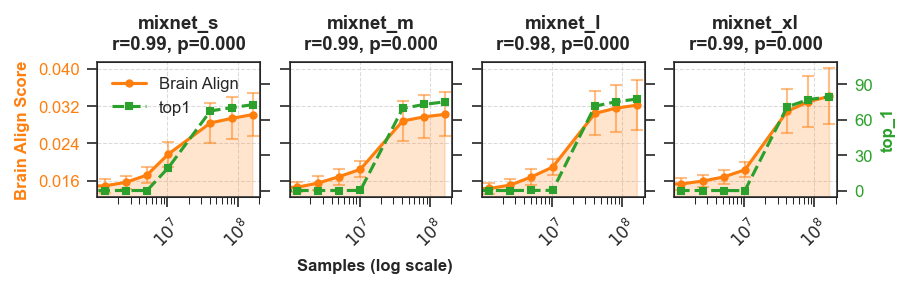

Saved top5_ema plot


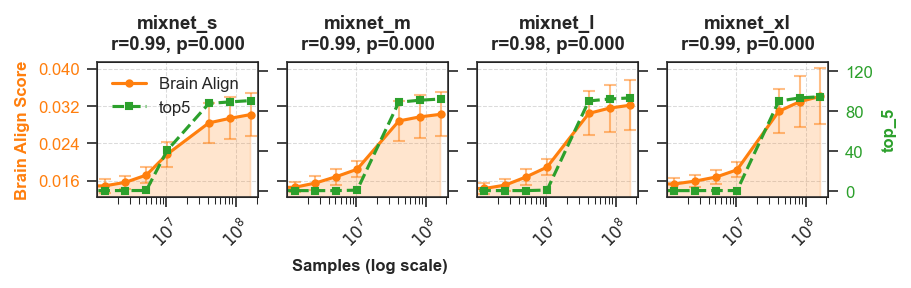

In [26]:
plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

import numpy as np
import scipy.stats as stats
import os
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import ScalarFormatter, LogLocator, FuncFormatter

# Define your benchmarks and models
DEFAULT_MODELS = ['mixnet_s', 'mixnet_m', 'mixnet_l', 'mixnet_xl']
benchmarks = ['top1', 'top5']
# Define custom colors
brain_color = "#ff7f0e"  # green for brain Align
benchmark_color = "#2ca02c"  # Red for benchmark error rate
# palette = {"Language": "#1f77b4", "Vision": "#ff7f0e"}

# Define function for scientific format on x-axis
def format_func(x, pos):
    if x == 0:
        return '0'
    else:
        exponent = int(np.log10(x))
        return r'$10^{%d}$' % exponent


for use_ema in [True]:

    for benchmark in benchmarks:
        # For each benchmark, create a separate row of plots (one for each model)
        ax2_ymax = vision_performance_df[vision_performance_df['use_ema'] == use_ema][benchmark].max()
        ax2_ymin = vision_performance_df[vision_performance_df['use_ema'] == use_ema][benchmark].min()

        ax2_ymax = ax2_ymax + (ax2_ymax - ax2_ymin) * 0.375
        ax2_ymin = ax2_ymin - (ax2_ymax - ax2_ymin) * 0.05

        # Create a figure for this benchmark with reduced spacing between subplots
        fig, axes = plt.subplots(1, len(DEFAULT_MODELS), figsize=(6, 1.85))
        fig.subplots_adjust(wspace=0.2)  # Reduced spacing between subplots

        # For each model, create a dual y-axis plot
        for i, model in enumerate(DEFAULT_MODELS):
            ax1 = axes[i]

            # Get brain Align data for this model
            brain_data = vision_max_region_df[vision_max_region_df['src_model'] == model]

            # Group by samples and calculate mean and std for error bars
            grouped_brain = brain_data.groupby('samples')['score'].agg(['mean', 'std', 'count']).reset_index()
            grouped_brain.fillna({'std': 0}, inplace=True)  # Handle NaN values in std

            # Calculate 95% confidence interval (CI)
            grouped_brain['ci_95'] = grouped_brain.apply(
                lambda row: stats.t.ppf(0.975, row['count']-1) * row['std'] / np.sqrt(row['count'])
                if row['count'] > 1 else 0, axis=1)

            # Plot brain Align score with error bars
            brain_line, = ax1.plot(grouped_brain['samples'], grouped_brain['mean'],
                     color=brain_color, marker='o', markersize=3, linewidth=1.5,
                     label='Brain Align')

            # Add error bars with 95% CI
            ax1.errorbar(grouped_brain['samples'], grouped_brain['mean'],
                        yerr=grouped_brain['ci_95'],
                        fmt='none', ecolor=brain_color, alpha=0.5,
                        capsize=3, capthick=1)

            # Add light shadow/area under the curve for visual emphasis
            ax1.fill_between(grouped_brain['samples'], 0, grouped_brain['mean'],
                             color=brain_color, alpha=0.2)

            ax1.set_xscale('log')
            ax1.set_ylim(0.005 + 0.0075, 0.034 + 0.0075)

            # Reduce y-tick density on first axis
            ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

            # Set up x-axis with scientific notation for all major ticks
            ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
            ax1.xaxis.set_major_locator(LogLocator(base=10, numticks=4))

            # Create second y-axis for benchmark error rate
            ax2 = ax1.twinx()

            # Get benchmark data for this model
            perf_data = vision_performance_df[(vision_performance_df['src_model'] == model) & (vision_performance_df['use_ema'] == use_ema)]

            # Reduce y-tick density on second axis
            ax2.yaxis.set_major_locator(plt.MaxNLocator(4))

            # Show y-axis labels and ticks only on leftmost and rightmost plots
            if i == 0:
                # Only show left y-axis (Brain Align) on leftmost plot
                ax1.set_ylabel('Brain Align Score', color=brain_color, fontweight='bold')
                ax1.tick_params(axis='y', labelcolor=brain_color)
                # Hide right y-axis ticks on leftmost plot
                ax2.tick_params(axis='y', labelleft=False, labelright=False)
            elif i == len(DEFAULT_MODELS) - 1:
                # Only show right y-axis (Error Rate) on rightmost plot
                ax2.set_ylabel(benchmark[:-1] + '_' + benchmark[-1], color=benchmark_color, fontweight='bold')
                ax2.tick_params(axis='y', labelcolor=benchmark_color)
                # Hide left y-axis ticks on rightmost plot
                ax1.tick_params(axis='y', labelleft=False, labelright=False)
            else:
                # Hide both y-axes ticks on middle plots
                ax1.tick_params(axis='y', labelleft=False, labelright=False)
                ax2.tick_params(axis='y', labelleft=False, labelright=False)

            # Plot the data and calculate correlation
            if benchmark in perf_data.columns:
                error_rate = perf_data[benchmark]
                # Plot benchmark error rate
                error_line, = ax2.plot(perf_data['samples'], error_rate,
                         color=benchmark_color, linestyle='--', marker='s',
                         markersize=3, linewidth=1.5, label='Acc')

                # Calculate Pearson correlation between Brain Align scores and benchmark performance
                # First, we need to align the data points based on samples
                brain_samples = grouped_brain['samples'].values
                perf_samples = perf_data['samples'].values

                # Find common x-values (samples) to calculate correlation
                common_x = np.intersect1d(brain_samples, perf_samples)

                if len(common_x) > 1:  # Need at least 2 points for correlation
                    brain_values = [grouped_brain[grouped_brain['samples'] == x]['mean'].values[0] for x in common_x]
                    perf_values = [error_rate[perf_data['samples'] == x].values[0] for x in common_x]

                    # Calculate Pearson correlation and p-value
                    corr, p_value = stats.pearsonr(brain_values, perf_values)

                    # Add correlation and p-value to the title
                    model_str = model
                    ax1.set_title(f'{model_str}\nr={corr:.2f}, p={p_value:.3f}', fontweight='bold')
                else:
                    # Not enough data points for correlation
                    model_str = model
                    ax1.set_title(f'{model_str}\n(insufficient data for corr)', fontweight='bold')

                # Add legend to the first plot (i=0) in each benchmark row
                if i == 0:
                    # Create legend for both lines in the first plot
                    lines = [brain_line, error_line]
                    labels = ['Brain Align', benchmark]
                    ax1.legend(lines, labels, loc='upper left', frameon=False)
            else:
                # No benchmark data available
                model_str = model
                ax1.set_title(f'{model_str}', fontweight='bold')

            # Only add x-axis label to middle plots
            if i == len(DEFAULT_MODELS) // 2 - 1:
                ax1.set_xlabel('Samples (log scale)', fontweight='bold', loc='right')

            # Make spines thinner to match tick thickness
            for spine in ax1.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.8)  # Thinner lines to match tick thickness
                spine.set_edgecolor('#333333')
            ax2.set_ylim(ax2_ymin, ax2_ymax)

            # Add grid for better readability
            ax1.grid(True, linestyle='--', alpha=0.7)
            ax1.tick_params(axis='x', rotation=45)

            # Set tick parameters to be thinner
            ax1.tick_params(axis='both', width=0.8)
            ax2.tick_params(axis='both', width=0.8)

        # Tight layout with additional padding reduction
        plt.tight_layout(pad=0.5)

        suffix = '_ema' if use_ema else ''

        os.makedirs(f'{FIGURES_DIR}/training/vision/performance', exist_ok=True)
        plt.savefig(f'{FIGURES_DIR}/training/vision/performance/{benchmark}{suffix}.pdf', bbox_inches='tight')
        print(f'Saved {benchmark}{suffix} plot')
        plt.show()

/mnt/home/floyed/code_for_brain_align/figures/wo_title.pdf


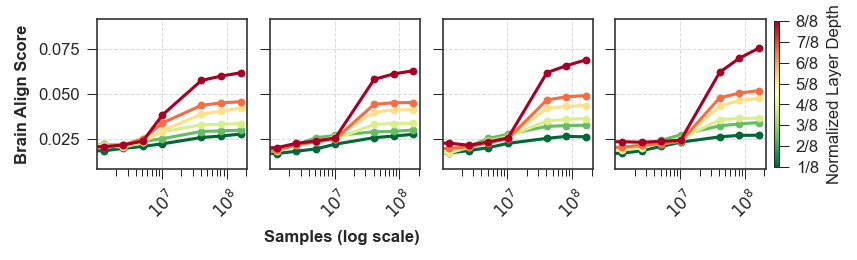

/mnt/home/floyed/code_for_brain_align/figures/w_title.pdf


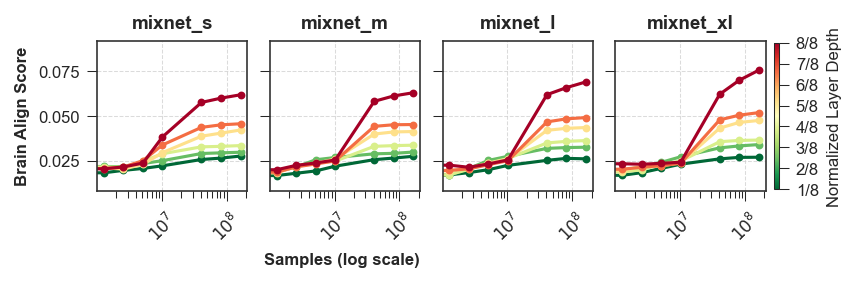

In [27]:

import numpy as np
from scipy.signal import savgol_filter
from matplotlib.ticker import ScalarFormatter, LogLocator, FuncFormatter

plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})


# Define custom colors
brain_color = "#1f77b4"  # Blue for brain Align
benchmark_color = "#d62728"  # Red for benchmark error rate

for title in [False, True]:
    # Create a colormap for layers
    layer_cmap = plt.get_cmap('RdYlGn_r')

    # For the layer visualization, create one consolidated figure with 6 subplots (one per model)
    fig2, axes2 = plt.subplots(1, len(DEFAULT_MODELS), figsize=(5.75, 1.3))
    fig2.subplots_adjust(wspace=0.15)  # Reduced spacing between subplots

    # Get max number of layers across all models for consistent coloring
    max_layers = max([len(vision_max_region_df_avg_subj[vision_max_region_df_avg_subj['src_model'] == model]['src_feature'].unique())
                     for model in DEFAULT_MODELS])

    # Create a normalization for the colormap
    norm = mpl.colors.Normalize(vmin=0, vmax=max_layers-1)


    # For each model, create a plot showing layer-wise scores
    for i, model in enumerate(DEFAULT_MODELS):
        ax = axes2[i]

        # Get data for this model
        data = vision_max_region_df_avg_subj[vision_max_region_df_avg_subj['src_model'] == model]

        # Get layers and sort them
        layers = sorted(data['src_feature'].unique(),
                       key=lambda x: int(x.replace('layer', '')) if 'layer' in str(x) and x.replace('layer', '').isdigit() else x)

        # Plot each layer
        for j, layer in enumerate(layers):
            layer_data = data[data['src_feature'] == layer]

            # Get values for this layer
            x_values = layer_data['samples'].values
            y_values = layer_data['score'].values

            # Sort the values by x for proper smoothing
            sort_idx = np.argsort(x_values)
            x_sorted = x_values[sort_idx]
            y_sorted = y_values[sort_idx]

            # Use the layer's position for consistent coloring
            color = layer_cmap(j / max(1, len(layers)-1))

            ax.plot(x_sorted, y_sorted,
                    color=color, marker='o', markersize=2.75, linewidth=1.5)

        # Format the plot
        ax.set_xscale('log')
        ax.set_ylim(0.008, 0.092)

        # Only show y-ticks and label on leftmost plot
        if i == 0:
            ax.set_ylabel('Brain Align Score', fontweight='bold')
        else:
            ax.tick_params(axis='y', labelleft=False)

        # Extract model name without the suffix for a cleaner display
        model_str = model
        if title:
            ax.set_title(f'{model_str}', fontweight='bold')

        # Add x-axis label to middle plots
        if i == len(DEFAULT_MODELS) // 2 - 1:
            ax.set_xlabel('Samples (log scale)', fontweight='bold', loc='right')

        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)

        # Format x-axis to show scientific notation
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'$10^{{{int(np.log10(x))}}}$' if x > 0 else '0'))
        ax.xaxis.set_major_locator(LogLocator(base=10, numticks=4))
        ax.tick_params(axis='x', rotation=45)

        # Add a box around the plot for better visibility
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)  # Thinner lines to match tick thickness
            spine.set_edgecolor('#333333')

    # Create a custom colorbar
    cax = fig2.add_axes([0.91, 0.12, 0.005, 0.75])  # [left, bottom, width, height]
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=layer_cmap, norm=norm, orientation='vertical')

    # Create normalized labels (1/8, 2/8, etc.)
    num_ticks = 8  # You can adjust this number based on preference
    tick_positions = np.linspace(0, max_layers-1, num_ticks)
    tick_labels = [f"{i+1}/{num_ticks}" for i in range(num_ticks)]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Normalized Layer Depth')

    os.makedirs(f'{FIGURES_DIR}/training/vision/layer-wise', exist_ok=True)

    if title:
        filename = 'w_title'
    else:
        filename = 'wo_title'
    plt.savefig(f'{FIGURES_DIR}/training/vision/layer-wise/{filename}.pdf', bbox_inches='tight')
    print(f'{FIGURES_DIR}/{filename}.pdf')
    plt.show()